#Linear Regression

Epoch 100, Loss: 0.8145928978919983
Epoch 200, Loss: 0.20157501101493835
Epoch 300, Loss: 0.07039119303226471
Epoch 400, Loss: 0.02915543131530285
Epoch 500, Loss: 0.014007249847054482
Epoch 600, Loss: 0.007985162548720837
Epoch 700, Loss: 0.005475305486470461
Epoch 800, Loss: 0.004395240917801857
Epoch 900, Loss: 0.003919526934623718
Epoch 1000, Loss: 0.003706322517246008

Test Mean Squared Error: 0.003795735538005829



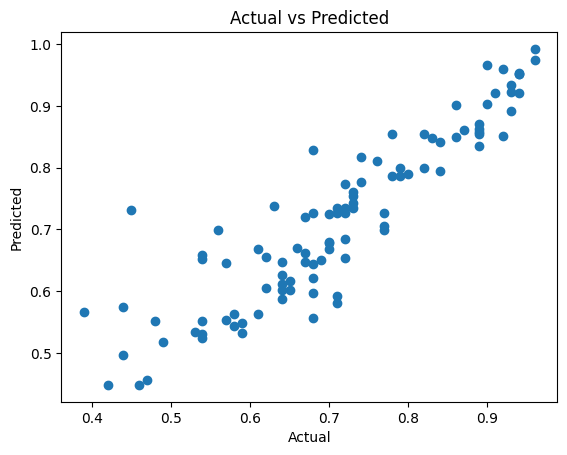

In [30]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Loading the dataset
df = pd.read_csv('/content/Admission_Predict_A3.csv')

# Performing scaling using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['Serial No.', 'Chance of Admit ']))

# Converting data into TensorFlow tensors
X_train, X_test, y_train, y_test = train_test_split(scaled_features, df['Chance of Admit '], test_size=0.2, random_state=42)

X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train.values.reshape(-1, 1), dtype=tf.float32)

# Initializing weights and bias
weights = tf.Variable(tf.random.normal(shape=(X_train_tensor.shape[1], 1)))
bias = tf.Variable(tf.random.normal(shape=(1,)))

# Defining linear regression model
def linear_regression(x):
    return tf.matmul(x, weights) + bias

# Defining loss function
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# SGD optimizer
optimizer = tf.optimizers.SGD(learning_rate=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = linear_regression(X_train_tensor)
        loss = mean_squared_error(y_train_tensor, predictions)
    gradients = tape.gradient(loss, [weights, bias])
    optimizer.apply_gradients(zip(gradients, [weights, bias]))

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

# Evaluating the model
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test.values.reshape(-1, 1), dtype=tf.float32)

test_predictions = linear_regression(X_test_tensor)
mse = mean_squared_error(y_test_tensor, test_predictions).numpy()
print(f'\nTest Mean Squared Error: {mse}\n')

# Plot of actual vs predicted probabilities
plt.scatter(y_test, test_predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


#Logistic Regression without binning

In [31]:
# Convert y_train to binary values with threshold of 0.5
y_train_binary = (y_train > 0.5).astype(int)
y_test_binary = (y_test > 0.5).astype(int)
# Convert data into TensorFlow tensors
y_train_binary_tensor = tf.constant(y_train_binary.values.reshape(-1, 1), dtype=tf.float32)

y_test_binary_tensor = tf.constant(y_test_binary.values.reshape(-1, 1), dtype=tf.float32)
# Initializing weights and bias for binary logistic regression
weights_binary = tf.Variable(tf.random.normal(shape=(X_train_tensor.shape[1], 1)))
bias_binary = tf.Variable(tf.random.normal(shape=(1,)))

# Defining logistic regression model with sigmoid activation
def logistic_regression_binary(x):
    return tf.nn.sigmoid(tf.matmul(x, weights_binary) + bias_binary)

# Defining binary cross entropy loss function
def binary_cross_entropy_loss(y_true, y_pred):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))

# SGD optimizer for binary logistic regression
optimizer_binary = tf.optimizers.SGD(learning_rate=0.01)

# Training loop for binary logistic regression
epochs_binary = 1000
for epoch in range(epochs_binary):
    with tf.GradientTape() as tape:
        predictions_binary = logistic_regression_binary(X_train_tensor)
        loss_binary = binary_cross_entropy_loss(y_train_binary_tensor, predictions_binary)
    gradients_binary = tape.gradient(loss_binary, [weights_binary, bias_binary])
    optimizer_binary.apply_gradients(zip(gradients_binary, [weights_binary, bias_binary]))

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss_binary.numpy()}')

# Evaluation for binary logistic regression
test_predictions_binary = logistic_regression_binary(X_test_tensor)
test_predictions_binary_rounded = tf.round(test_predictions_binary)
accuracy_binary = tf.reduce_mean(tf.cast(tf.equal(test_predictions_binary_rounded, y_test_binary_tensor), tf.float32)).numpy()
print(f'\nBinary Logistic Regression Accuracy: {accuracy_binary}\n')

Epoch 100, Loss: 0.5057424902915955
Epoch 200, Loss: 0.5037866830825806
Epoch 300, Loss: 0.5018895864486694
Epoch 400, Loss: 0.5000471472740173
Epoch 500, Loss: 0.4982554614543915
Epoch 600, Loss: 0.49651095271110535
Epoch 700, Loss: 0.49481040239334106
Epoch 800, Loss: 0.4931505620479584
Epoch 900, Loss: 0.49152863025665283
Epoch 1000, Loss: 0.48994189500808716

Binary Logistic Regression Accuracy: 0.6000000238418579



#Logistic Regression with binning

In [32]:
# Implementing logistic regression with softmax activation function
# Assuming y_train has been binned into three classes: low, medium, and high

# Convert y_train to one-hot encoding
bin_edges=[0.3,0.5,0.7,1.0]
y_train_onehot = pd.get_dummies(pd.cut(y_train, bins=bin_edges, labels=['low', 'medium', 'high']))
y_test_onehot = pd.get_dummies(pd.cut(y_test, bins=bin_edges, labels=['low', 'medium', 'high']))
# Convert data into TensorFlow tensors
y_train_tensor = tf.constant(y_train_onehot.values, dtype=tf.float32)
y_test_tensor = tf.constant(y_test_onehot.values, dtype=tf.float32)

# Initialize weights and bias for logistic regression
weights_logistic = tf.Variable(tf.random.normal(shape=(X_train_tensor.shape[1], 3)))
bias_logistic = tf.Variable(tf.random.normal(shape=(3,)))

# Define logistic regression model with softmax activation
def logistic_regression(x):
    return tf.nn.softmax(tf.matmul(x, weights_logistic) + bias_logistic)

# Define cross entropy loss function
def cross_entropy_loss(y_true, y_pred):
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# SGD optimizer for logistic regression
optimizer_logistic = tf.optimizers.SGD(learning_rate=0.01)

# Training loop for logistic regression
epochs_logistic = 50
for epoch in range(epochs_logistic):
    with tf.GradientTape() as tape:
        predictions_logistic = logistic_regression(X_train_tensor)
        loss_logistic = cross_entropy_loss(y_train_tensor, predictions_logistic)
    gradients_logistic = tape.gradient(loss_logistic, [weights_logistic, bias_logistic])
    optimizer_logistic.apply_gradients(zip(gradients_logistic, [weights_logistic, bias_logistic]))

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss_logistic.numpy()}')

# Evaluation for logistic regression
test_predictions_logistic = logistic_regression(X_test_tensor)
test_predictions_binary_rounded = tf.round(test_predictions_logistic)
accuracy_binary = tf.reduce_mean(tf.cast(tf.equal(test_predictions_binary_rounded, y_test_tensor), tf.float32)).numpy()
print(f'\nBinary Logistic Regression Accuracy: {accuracy_binary}\n')


Epoch 10, Loss: 2.550340175628662
Epoch 20, Loss: 2.3757216930389404
Epoch 30, Loss: 2.2186906337738037
Epoch 40, Loss: 2.0783231258392334
Epoch 50, Loss: 1.9531292915344238

Binary Logistic Regression Accuracy: 0.5833333134651184



Softmax converts raw scores into probabilities, aiding multiclass classification by providing a probability distribution. It facilitates decision-making by selecting the class with the highest probability, and its differentiability allows for effective training using backpropagation. Paired with cross-entropy loss, softmax optimizes the model to output higher probabilities for correct classes. Additionally, it normalizes scores, improving stability and convergence during training.

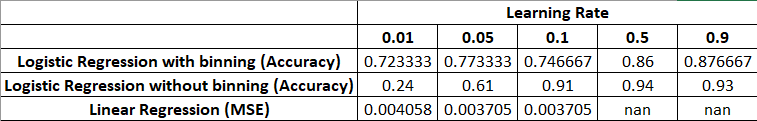

#Correlation Coefficient


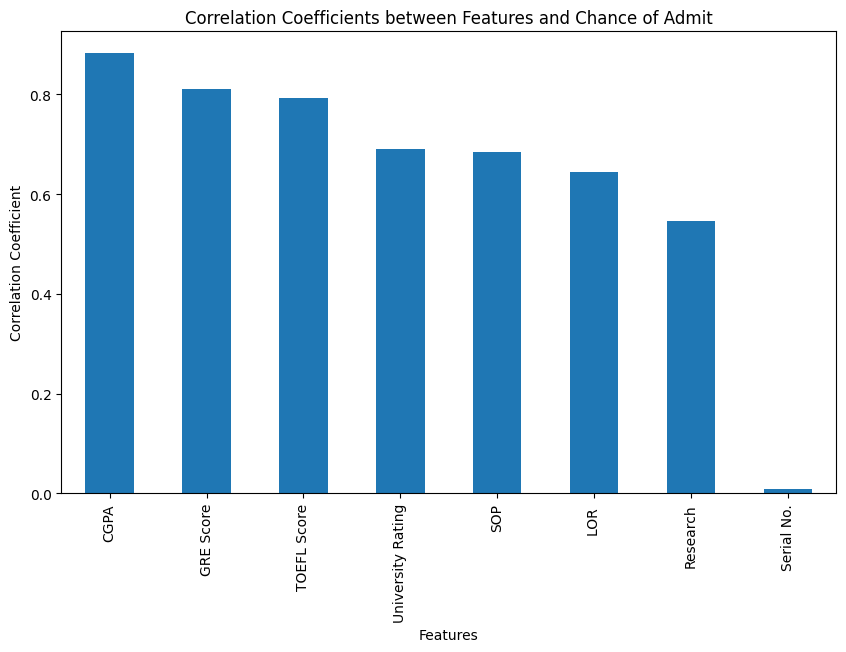

In [33]:
# Calculate correlation coefficients
correlation = df.corr()['Chance of Admit '].drop('Chance of Admit ')
# Sort correlation coefficients
correlation_sorted = correlation.abs().sort_values(ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
correlation_sorted.plot(kind='bar')
plt.title('Correlation Coefficients between Features and Chance of Admit')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()


#Feature Selection

In [34]:
# Select top features based on correlation
top_features = correlation_sorted.head(5).index.tolist()

# Retrain the model with selected features
X_train_selected = X_train[:, [df.columns.get_loc(feature) for feature in top_features]]
X_test_selected = X_test[:, [df.columns.get_loc(feature) for feature in top_features]]

X_train_selected = tf.constant(X_train_selected, dtype=tf.float32)
X_test_selected = tf.constant(X_test_selected, dtype=tf.float32)
# Initialize weights and bias
weights_selected = tf.Variable(tf.random.normal(shape=(X_train_selected.shape[1], 1), dtype=tf.float32))
bias_selected = tf.Variable(tf.random.normal(shape=(1,), dtype=tf.float32))

# Define linear regression model with selected features
def linear_regression_selected(x):
    return tf.matmul(x, weights_selected) + bias_selected

# Initialize optimizer
optimizer = tf.optimizers.SGD(learning_rate=0.01)

# Training loop with selected features
epochs_selected = 1000
for epoch in range(epochs_selected):
    with tf.GradientTape() as tape:
        predictions_selected = linear_regression_selected(X_train_selected)
        loss_selected = mean_squared_error(y_train_tensor, predictions_selected)
    gradients_selected = tape.gradient(loss_selected, [weights_selected, bias_selected])

    # Update weights and bias using gradients
    optimizer.apply_gradients(zip(gradients_selected, [weights_selected, bias_selected]))

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss_selected.numpy()}')

# Evaluate the model with selected features
test_predictions_selected = linear_regression_selected(X_test_selected)
mse_selected = mean_squared_error(y_test_tensor, test_predictions_selected).numpy()
print(f'\nTest Mean Squared Error with selected features: {mse_selected}\n')


Epoch 100, Loss: 0.3345811367034912
Epoch 200, Loss: 0.25025415420532227
Epoch 300, Loss: 0.2300383448600769
Epoch 400, Loss: 0.22446607053279877
Epoch 500, Loss: 0.222880557179451
Epoch 600, Loss: 0.22241930663585663
Epoch 700, Loss: 0.22228236496448517
Epoch 800, Loss: 0.2222408801317215
Epoch 900, Loss: 0.22222809493541718
Epoch 1000, Loss: 0.22222410142421722

Test Mean Squared Error with selected features: 0.2222236841917038



#K-Fold

In [35]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
# Number of folds for k-fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits)


bin_encoder = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
binned_target = bin_encoder.fit_transform(df['Chance of Admit '].values.reshape(-1, 1))
# Initializing lists to store evaluation metrics
linear_regression_mses = []
logistic_regression_mses = []

# Performing k-fold cross-validation
for train_index, test_index in kf.split(scaled_features):
    X_train_fold, X_test_fold = scaled_features[train_index], scaled_features[test_index]
    y_train_fold, y_test_fold = binned_target[train_index], binned_target[test_index]

    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_fold, y_train_fold)
    lin_reg_predictions = lin_reg.predict(X_test_fold)
    linear_regression_mses.append(mean_squared_error(y_test_fold, lin_reg_predictions))

    # Logistic Regression
    log_reg = LogisticRegression()
    log_reg.fit(X_train_fold, y_train_fold)
    log_reg_predictions = log_reg.predict(X_test_fold)
    log_reg_mse = mean_squared_error(y_test_fold, log_reg_predictions)
    logistic_regression_mses.append(log_reg_mse)

# Computing average performance metrics
avg_linear_regression_mse = sum(linear_regression_mses) / n_splits
avg_logistic_regression_mse = sum(logistic_regression_mses) / n_splits

# Printing results
print(f'\nAverage MSE for Linear Regression: {avg_linear_regression_mse}\n')
print(f'Average Accuracy for Logistic Regression: {avg_logistic_regression_mse}\n')



Average MSE for Linear Regression: 0.1643203772143925

Average Accuracy for Logistic Regression: 0.194



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam